# Model PCEX

Model PCEX is introduced in chapter 4 of {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated` "Monetary Economics: An Integrated Approach to Credit, Money, Income, Production and Wealth". In its setup, the model has the same transactions and balance sheet as Model PC (see [here](GL06PC.ipynb)), but features expectations on disposable income and wealth. 

## Module Contents

As with all `MacroStat` models, PCEX is divided into Variables, Parameters (fixed constants), Scenarios, and the Behavior (model initialization and steps). The module-level documentation, such as all variables/parameters/scenarios and their notation or the behavioral equations associated with each function of `BehaviorPCEX.py` can be seen in:

```{eval-rst}
.. toctree::
    :maxdepth: 2

    Variables <GL06PCEX/variables.rst>
    Parameters <GL06PCEX/parameters.rst>
    Equations <GL06PCEX/equations.rst>
    Scenarios <GL06PCEX/scenarios.rst>
```

The remainder of this page gives an introduction to the model, notes on how it is implemented in `MacroStat` and then shows some of the model dynamics by replicating the relevant graphs of Godley and Lavoie (2006).

## Model Overview

### Behavioral Equations

Unlike model [PC](GL06PC.ipynb), model PCEX is built with expectations. Specifically, the household forms expectations of its disposable income $YD^e$ and its expected wealth $V^e$. With these two variables, the remaining equations of the model are almost identical to model PC.

1. National Income
```{math}
:label: gl06_pcex_eq401_nationalIncome
Y(t) = C(t) + G(t)
```
2. Disposable income is national income and interest earnings minus taxes
```{math}
:label: gl06_pcex_eq402_disposableIncome
YD(t) = Y(t) - T(t) + r(t-1)\cdot B_h(t-1)
```
3. Taxes are a fixed share of income
```{math}
:label: gl06_pcex_eq403_taxes
T(t) = \Theta \cdot \left(Y(t) + r(t-1)\cdot B_h(t-1)\right)
```
4. Wealth increases by savings
```{math}
:label: gl06_pcex_eq404_wealth
V(t) = V(t-1) + (YD(t) - C(t))
```
5. Consumption is partially out of disposable income and wealth, **but now based on expected disposable income**
```{math}
:label: gl06_pcex_eq405E_consumption
C(t) = \alpha_1\cdot YD^e(t) + \alpha_2\cdot V(t-1)
```
6. The share of bills in wealth depends on **expected wealth and expected disposable income**
```{math}
:label: gl06_pcex_eq407E_householdBondHoldings
\frac{B_d(t)}{V^e(t)}=\lambda_0 + \lambda_1\cdot r(t) - \lambda_2\cdot\left(\frac{YD^e(t)}{V^e(t)}\right)
```
7. The share of cash in wealth (6A)
```{math}
:label: gl06_pcex_eq406E_householdCashHoldings
\frac{H_d(t)}{V^e(t)}=(1-\lambda_0) - \lambda_1\cdot r(t) + \lambda_2\cdot\left(\frac{YD^e(t)}{V^e(t)}\right)
```
8. Household cash demand can also be described by the difference between **expected wealth** and **demand for bills**
```{math}
:label: gl06_pcex_eq413_householdDepositDemand
H_d(t) = V^e(t) - B_h(t)
```
8. **expected wealth** depends on **expected disposable income**
```{math}
:label: gl06_pcex_eq414_householdExpectedWealth
V^e(t) = V(t-1) + (YD^e(t) - C(t))
```
9. The household's realized cash holdings then depend on the realisation of household wealth
```{math}
:label: gl06_pcex_eq406_householdDeposits
H_h(t) = V(t) - B_h(t)
```
10. Where we assume now that the household's demand for bills is met.
```{math}
:label: gl06_pcex_eq415_householdBillHoldings
B_h(t) = B_d(t)
```
11. The change in the stock of outstanding government bills (also known as the government's budget constraint). The first part represents government outlays (direct purchases and interest payments) while the second represents government revenues (taxes and central bank profits)
```{math}
:label: gl06_pcex_eq408_governmentBillIssuance
:nowrap:

\begin{align}
\Delta B_s(t) &= B_s(t) - B_s(t-1)\\
&= (G(t) + r(t-1)\cdot B_s(t-1)) - (T(t) + r(t-1)\cdot B_{CB}(t-1))
\end{align}
```
12. The change in money circulating 
```{math}
:label: gl06_pcex_eq409_moneyIssuance
\Delta H_s(t) = H_s(t) - H_s(t-1) = \Delta B_{CB}
```
13. Bills held by the central bank, the central bank purchases all of the bills issued by the government that the households are not willing to buy given the current interest rate. Combined with {eq}`gl06_pc_eq409_moneyIssuance` it implies the CB provides cash money on demand. Therefore, _the amount of cash in the system is endogeneous and demand-led_ while _the rate on bills is exogenous_.
```{math}
:label: gl06_pcex_eq410_centralBankBills
B_{CB}(t) = B_s(t) - B_h(t)
```
13. The interest rate is fixed
```{math}
:label: gl06_pcex_eq411_interestRate
r(t) = \bar{r}
```

With the redundant equation being
```{math}
:label: gl06_pcex_eq412_redundant
H_s(t) = H_h(t)
```

**Now we must still define how the expected disposable income is set**, as with model [SIMEX](GL06SIMEX.ipynb), we suppose that it is a simple extrapolation from prior levels (which is self-consistent in a steady state since the economy is not growing here). 
```{math}
:label: gl06_pcex_eq416_expectedDisposableIncome
YD^e(t) = YD(t-1)
```
Note that in {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated` this is equivalent to _Model PCEX1_, while _Model PCEX_ actually just assumes a random multiplicative term on the $YD$ determined by model PC. I do not here model this part, as it is only used as a demonstration in the book. 


### Transaction Flow Matrix

```{csv-table} Accounting Transaction Matrix for Model PCEX
:file: GL06PCEX/transaction_matrix.csv
:header-rows: 2
:stub-columns: 1
```

### Balance Sheet Matrix

```{csv-table} Balance Sheet for Model PCEX
:file: GL06PCEX/balance_sheet.csv
:header-rows: 2
:stub-columns: 1
```

## Implementation in MacroStat

Transposing these eleven equations to the `MacroStat` framework, we consider that there are:

1. Three parameters (fixed constants): $\alpha_1$, $\alpha_2$, and $\theta$ (see [Parameters](GL06PCEX/parameters.rst))
2. Two scenario variables : $G_d(t)$ and $W(t)$ (see [Scenarios](GL06PCEX/scenarios.rst))
3. The remaining tracked series are variables (see [Variables](GL06PCEX/variables.rst))

## Model Dynamics

### Preparatory Steps

In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import logging
import sys

# Import the necessary libraries for plotting
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

# Import the MacroStat get_model function
from macrostat.models import get_model

# Custom matplotlib style for the documentation
plt.style.use("../../macrostat.mplstyle")
# We show the logging output in the notebook
importlib.reload(logging)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

### Running the Simulation

First, we can run the model without any shocks to see the convergence to the steady state.

In [2]:
GL06PCEXClass = get_model("GL06PCEX")
model = GL06PCEXClass()
model.simulate()
output = model.variables.to_pandas()

INFO:root:Starting simulation. Scenario: 0


Here we can also check that the variables are healthy, which means that the redundant equations hold and that all the assets and liabilities are positive. For model PC, the redundant equation is that the household money stock equals the central bank money stock. 

:::{Note}
In numerical implementations, due to floating point precision it is unlikely that the redundant equation will hold exactly. Therefore, we check that the absolute percentage error is less than a given tolerance, in this case 1e-5. We use the absolute percentage error to appropriately scale the error for different magnitudes of the variables.
:::

In [3]:
model.variables.check_health(tolerance=1e-5)

True

An overview of the first 10 steps of the model

In [4]:
df=model.variables.to_pandas()
df.head(10).T

0    1       2          3          4  \
ConsumptionHousehold           0  0.0  0.0   0.000  16.000000  28.799999   
ConsumptionGovernment          0  0.0  0.0  20.000  20.000000  20.000000   
NationalIncome                 0  0.0  0.0  20.000  36.000000  48.799999   
InterestEarnedOnBillsHousehold 0  0.0  0.0   0.000   0.000000   0.300000   
CentralBankProfits             0  0.0  0.0   0.000   0.400000   0.420000   
Taxes                          0  0.0  0.0   4.000   7.200000   9.820000   
HouseholdMoneyStock            0  0.0  0.0  16.000  16.799999  17.680004   
CentralBankMoneyStock          0  0.0  0.0  16.000  16.800003  17.680002   
HouseholdBillStock             0  0.0  0.0   0.000  12.000000  21.599998   
GovernmentBillStock            0  0.0  0.0  16.000  28.800001  39.279999   
CentralBankBillStock           0  0.0  0.0  16.000  16.800001  17.680000   
Wealth                         0  0.0  0.0  16.000  28.799999  39.280003   
InterestRate                   0  0.0  0.0   0.025   0.025000   0.025000   
DisposableIncome               0  0.0  0.0  16.000  28.799999  39.279999   
ExpectedDisposableIncome       0  0.0  0.0   0.000  16.000000  28.799999   
ExpectedWealth                 0  0.0  0.0   0.000  16.000000  28.799999   
HouseholdBillDemand            0  0.0  0.0   0.000  12.000000  21.599998   

                                          5          6          7          8  \
ConsumptionHousehold           0  39.280003  47.856003  54.874001  60.617043   
ConsumptionGovernment          0  20.000000  20.000000  20.000000  20.000000   
NationalIncome                 0  59.280003  67.856003  74.874001  80.617043   
InterestEarnedOnBillsHousehold 0   0.540000   0.736500   0.897300   1.028887   
CentralBankProfits             0   0.442000   0.459900   0.474550   0.486539   
Taxes                          0  11.964001  13.718501  15.154261  16.329185   
HouseholdMoneyStock            0  18.396004  18.981991  19.461540  19.853958   
CentralBankMoneyStock          0  18.396004  18.981995  19.461544  19.853966   
HouseholdBillStock             0  29.459995  35.892002  41.155495  45.462776   
GovernmentBillStock            0  47.855999  54.873997  60.617039  65.316742   
CentralBankBillStock           0  18.396004  18.981995  19.461544  19.853966   
Wealth                         0  47.855999  54.873993  60.617035  65.316734   
InterestRate                   0   0.025000   0.025000   0.025000   0.025000   
DisposableIncome               0  47.856003  54.874001  60.617043  65.316742   
ExpectedDisposableIncome       0  39.279999  47.856003  54.874001  60.617043   
ExpectedWealth                 0  39.279995  47.856003  54.873993  60.617035   
HouseholdBillDemand            0  29.459995  35.892002  41.155495  45.462776   

                                          9  
ConsumptionHousehold           0  65.316742  
ConsumptionGovernment          0  20.000000  
NationalIncome                 0  85.316742  
InterestEarnedOnBillsHousehold 0   1.136569  
CentralBankProfits             0   0.496349  
Taxes                          0  17.290663  
HouseholdMoneyStock            0  20.175072  
CentralBankMoneyStock          0  20.175095  
HouseholdBillStock             0  48.987556  
GovernmentBillStock            0  69.162651  
CentralBankBillStock           0  20.175095  
Wealth                         0  69.162628  
InterestRate                   0   0.025000  
DisposableIncome               0  69.162643  
ExpectedDisposableIncome       0  65.316742  
ExpectedWealth                 0  65.316742  
HouseholdBillDemand            0  48.987556

### Convergence to the Steady State

The steady state for Model PCEX is equivalent to model PC, it just has delays in reathing the steady state. In {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated` models are initialized with almost all of the variables set to zero. For model PCEX the only non-zero item is that in period 0 the government demand is 20, i.e. the government creates 20 monetary units of demand.

To aid in our graphing, we can calculate the steady state solutions for the variables following the derivations in Section 4.5 of Godley and Lavoie {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated`:

```{math}
\begin{align}
G^\star(t) &= G(t)\\
r^\star(t) &= r(t)\\
\alpha_3 &= \frac{1-\alpha_1}{\alpha_2}\\
YD^\star(t) = YD^{e\star}(t) &= \frac{G^\star(t)}{\frac{\theta}{1-\theta} - r^\star(t)\cdot\left(\left(\lambda_0 + \lambda_1 r^\star(t) \right)\alpha_3 - \lambda_2\right)}\\
C^\star(t) &= YD^\star(t)\\
Y^\star(t) &= C^\star(t) + G^\star(t)\\
V^\star(t) = V^{e\star}(t) &= \alpha_3 YD^\star(t)\\
B_d^\star(t) = B_h^\star(t) &= \left(\left(\lambda_0 + \lambda_1 r^\star(t) \right)\alpha_3 - \lambda_2\right)\cdot YD^\star(t)\\
T^\star(t) &= \theta\cdot \left(Y^\star(t) + r^\star(t) B_h^\star(t)\right)\\
H_h^\star(t) &= V^{e\star}(t) - B_h^\star(t)\\
B_s^\star(t) &= \frac{r^\star(t) B_{CB}^\star(t) + T^\star(t) - G^\star(t)}{r^\star(t)}\\
B_{CB}^\star(t) &= B_s^\star(t) - B_h^\star(t)\\
H_s^\star(t) &= H_{s}(t-1) + (B_{CB}(t) - B_{CB}(t-1))
\end{align}
```

In macrostat, this solution has been implemented in the `compute_theoretical_steady_state()` function. We compute this now for `scenario=0`, which is the case without any shocks and constant government demand $G$ and interest rates $r$. 

In [5]:
model.compute_theoretical_steady_state(scenario=0)
steadystate = model.variables.to_pandas()

INFO:root:Computing theoretical steady state. Scenario: 0


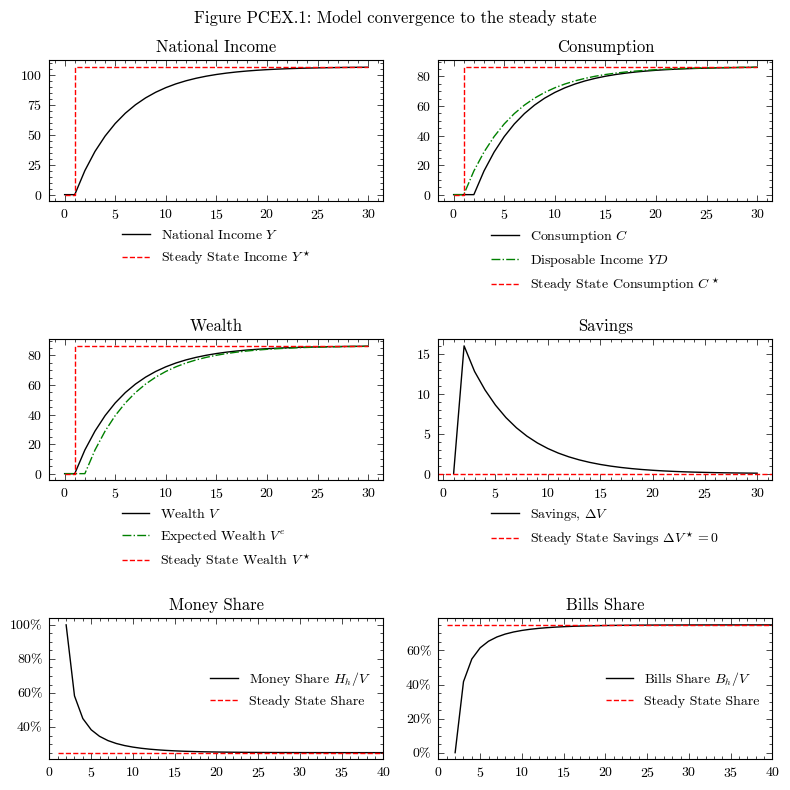

In [6]:
dfo = output.loc[:30]
dfs = steadystate.loc[:30]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].step(x=dfs.index,y=dfs["NationalIncome"], color='r', linestyle='--', label=r'Steady State Income $Y^\star$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['ConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].step(x=dfs.index,y=dfs["ConsumptionHousehold"], color='r', linestyle='--', label=r'Steady State Consumption $C^\star$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].step(x=dfs.index,y=dfs["Wealth"], color='r', linestyle='--', label=r'Steady State Wealth $V^\star$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].axhline(y=0, color='r', linestyle='--', label=r'Steady State Savings $\Delta V^\star=0$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
share_bills = steadystate['HouseholdBillStock'] / steadystate['Wealth']
axs[2,0].plot(output.index, output['HouseholdMoneyStock'] / output['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].step(x=share_bills.index,y=1-share_bills, color='r', linestyle='--', label='Steady State Share')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_xlim(0,40)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(output.index, output['HouseholdBillStock'] / output['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].step(x=share_bills.index,y=share_bills, color='r', linestyle='--', label='Steady State Share')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_xlim(0,40)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Figure PCEX.1: Model convergence to the steady state')
plt.tight_layout()
plt.show()


### Perturbation 1: An increase of 100 points in the rate of interest on bills ($r$)

Following the convergence to the steady state, we can study the effects of an increase in the rate on bills by 100bps (Figures 4.3 and 4.4 in {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated`).

`MacroStat` is set up to easily handle these scenarios. Much like in prior models, we simply define a new scenario `IncreaseInterestRate` and set the new rate to be 100 points higher $r=0.025+0.01$

In [7]:
model.parameters["scenario_trigger"] = 60
model.scenarios.add_scenario(
    name="IncreaseInterestRate",
    timeseries={"InterestRate":0.025 + 0.01}
)
model.simulate(scenario="IncreaseInterestRate")
output_rate_increase = model.variables.to_pandas()

INFO:root:Starting simulation. Scenario: 1


We then need to compute the new steady state values for the variables

In [8]:
model.compute_theoretical_steady_state(scenario="IncreaseInterestRate")
steadystate_rate_increase = model.variables.to_pandas()

INFO:root:Computing theoretical steady state. Scenario: 1


Now we can see how the model reacts to the shock.

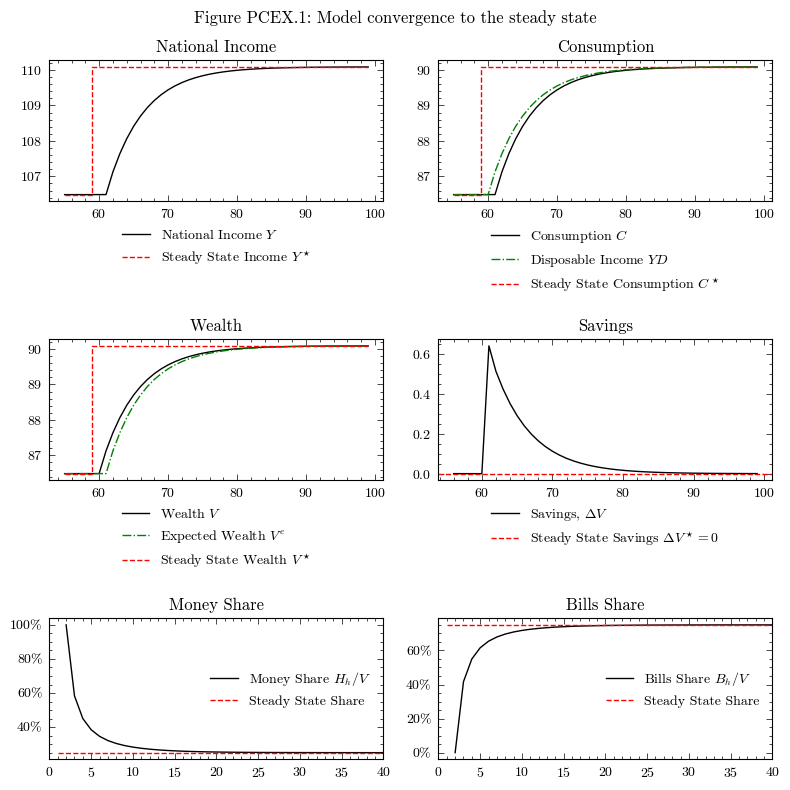

In [9]:
dfo = output_rate_increase.loc[55:]
dfs = steadystate_rate_increase.loc[55:]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].step(x=dfs.index,y=dfs["NationalIncome"], color='r', linestyle='--', label=r'Steady State Income $Y^\star$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['ConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].step(x=dfs.index,y=dfs["ConsumptionHousehold"], color='r', linestyle='--', label=r'Steady State Consumption $C^\star$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].step(x=dfs.index,y=dfs["Wealth"], color='r', linestyle='--', label=r'Steady State Wealth $V^\star$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].axhline(y=0, color='r', linestyle='--', label=r'Steady State Savings $\Delta V^\star=0$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
share_bills = steadystate['HouseholdBillStock'] / steadystate['Wealth']
axs[2,0].plot(output.index, output['HouseholdMoneyStock'] / output['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].step(x=share_bills.index,y=1-share_bills, color='r', linestyle='--', label='Steady State Share')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_xlim(0,40)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(output.index, output['HouseholdBillStock'] / output['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].step(x=share_bills.index,y=share_bills, color='r', linestyle='--', label='Steady State Share')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_xlim(0,40)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Figure PCEX.1: Model convergence to the steady state')
plt.tight_layout()
plt.show()


### Perturbation 2: An increase in the propensity to consume out of income ($\alpha_1$)

Following the convergence to the steady state, we can study the effects of an increase of the household sector's propensity to consume out of income.

`MacroStat` is set up to easily handle time-dependent changes in the values of parameters (useful for scenarios and calibration). It specifically supports two types of paramer-shocks: multiplicative and additive. Thus, if `pname` is the name of the parameter, it checks for the existence of `pname_multiply` and `pname_add` in the scenarios to edit them. 

Therefore, let us add this kind of scenario can easily be implemented in the `MacroStat` version by adding a scenario:
1. In the file `Scenarios` specific to `GL06PCEX` (i.e. `macrostat/models/GL06PCEX/scenarios.py`) I added the `PropensityToConsumeIncome_add` default_value, and set it to zero. 
2. Noting that we have convergence to the steady state at period 60, let us set this as the scenario trigger
3. We then need a new timeseries for the scenario, where we have `PropensityToConsumeIncome_add=0.01`

In [10]:
model.parameters["scenario_trigger"] = 60
model.scenarios.add_scenario(
    name="PropensityToConsumeIncomeIncrease",
    timeseries={"PropensityToConsumeIncome_add":0.01}
)
model.simulate(scenario="PropensityToConsumeIncomeIncrease")
output_cons_propensity_increase = model.variables.to_pandas()

INFO:root:Starting simulation. Scenario: 2


We then need to compute the new steady state values for the variables

In [11]:
model.compute_theoretical_steady_state(scenario="PropensityToConsumeIncomeIncrease")
steadystate_cons_propensity_increase = model.variables.to_pandas()

INFO:root:Computing theoretical steady state. Scenario: 2


Now we can see how the model reacts to the shock.

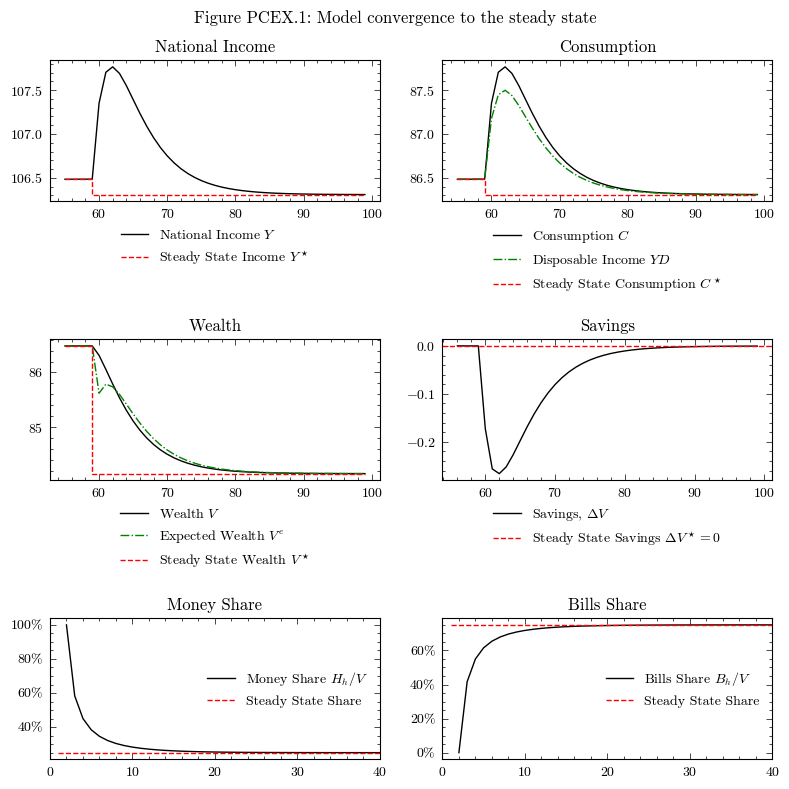

In [12]:
dfo = output_cons_propensity_increase.loc[55:]
dfs = steadystate_cons_propensity_increase.loc[55:]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].step(x=dfs.index,y=dfs["NationalIncome"], color='r', linestyle='--', label=r'Steady State Income $Y^\star$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['ConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].step(x=dfs.index,y=dfs["ConsumptionHousehold"], color='r', linestyle='--', label=r'Steady State Consumption $C^\star$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].step(x=dfs.index,y=dfs["Wealth"], color='r', linestyle='--', label=r'Steady State Wealth $V^\star$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].axhline(y=0, color='r', linestyle='--', label=r'Steady State Savings $\Delta V^\star=0$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
share_bills = steadystate['HouseholdBillStock'] / steadystate['Wealth']
axs[2,0].plot(output.index, output['HouseholdMoneyStock'] / output['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].step(x=share_bills.index,y=1-share_bills, color='r', linestyle='--', label='Steady State Share')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_xlim(0,40)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(output.index, output['HouseholdBillStock'] / output['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].step(x=share_bills.index,y=share_bills, color='r', linestyle='--', label='Steady State Share')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_xlim(0,40)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Figure PCEX.1: Model convergence to the steady state')
plt.tight_layout()
plt.show()
